In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
!pip install shap
import shap
from scipy.stats.stats import pearsonr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/Data Open Championship 2022/2-data/IPEDS_Dataset_Encoded

/content/drive/.shortcut-targets-by-id/1VhaW8PqOm10rxodZbXmRV2GHxBJq9Qxh/Data Open Championship 2022/2-data/IPEDS_Dataset_Encoded


In [ ]:
ls

'12-Month Enrollment'/             'Graduation Rates'/
'Academic Libraries'/              'Institutional Characteristics'/
'Admission and Test Scores'/       'Institutional Finances'/
 Completions/                      'Outcome Measures'/
'Employees by Assigned Position'/  'Student Financial Aid'/
'Fall Enrollment'/


In [133]:
path = '/content/drive/.shortcut-targets-by-id/1VhaW8PqOm10rxodZbXmRV2GHxBJq9Qxh/Data Open Championship 2022/2-data/preprocessed'
path2 = '/content/drive/.shortcut-targets-by-id/1VhaW8PqOm10rxodZbXmRV2GHxBJq9Qxh/Data Open Championship 2022/2-data/IPEDS_Dataset_Encoded/Student Financial Aid'

In [140]:
df = pd.read_csv(path2+'/SFA_1415-2021_data.csv')
df2 = pd.read_csv(path2+'/SFAV_1415-2021_data.csv')
df3 = pd.read_csv(path2+'/SFAV_1415-2021_data_descriptions.xlsx')

UnicodeDecodeError: ignored

In [138]:
# df['po9_a'].median()
df2.columns[df2.columns.str.startswith("po9_a")].tolist()

['po9_a']

In [96]:
df[df['oloan_t'] > 0].groupby('year')['oloan_t','oloan_p'].median()

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,oloan_t,oloan_p
year,,
1415,103198.0,6.0
1516,120126.0,5.0
1617,123501.0,6.0
1718,139837.5,6.0
1819,165195.0,6.0
1920,146317.0,6.0
2021,141649.0,6.0


fin aid

- SFA_1415-2021.csv
- Dataset Overview: # of fin aid programs.

In [124]:
train = pd.read_csv(path + '/absolute/df_all_pub_train.csv')
test = pd.read_csv(path + '/absolute/df_all_pub_test.csv')
# train = pd.read_csv(path + '/relative/df_all_pub_train.csv')
# test = pd.read_csv(path + '/relative/df_all_pub_test.csv')
# train.head()


In [125]:
train = train[train['gradrate_4yr_completer150_'].notna()]
test = test[test['gradrate_4yr_completer150_'].notna()]


# train = train[train['completion_stem'].notna()]
# test = test[test['completion_stem'].notna()]

In [5]:
set(train.year)

{2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, nan, 2015.0}

In [114]:
covariates = ["time"] # "time"
covariates += train.columns[train.columns.str.startswith("charac")].tolist()
covariates += train.columns[train.columns.str.startswith("diversity")].tolist()
covariates += train.columns[train.columns.str.startswith("services")].tolist()
covariates += train.columns[train.columns.str.startswith("speclearning")].tolist()
covariates.remove("speclearning_distanceonly")
covariates

['time',
 'charac_medical',
 'charac_urban',
 'charac_landgrant',
 'charac_instsize',
 'charac_openadmission',
 'charac_religion_no',
 'diversity_historicallyblackcollege',
 'diversity_tribal',
 'diversity_disab',
 'diversity_veteranprograms',
 'diversity_athleticprograms',
 'services_hospital',
 'services_remedial',
 'services_counseling',
 'services_employment',
 'services_placement',
 'services_daycare',
 'services_library',
 'services_library_physical',
 'services_library_digital',
 'speclearning_distancecourse',
 'speclearning_distancepogram',
 'speclearning_parttime',
 'speclearning_studyabroad',
 'speclearning_eveningcollege',
 'speclearning_rotc']

In [115]:
predictors_finance = [
  "academic support - current year total",
"academic support - salaries and wages",
"additional (or decreased) pension expense",
"auxiliary enterprises -- current year total",
"auxiliary enterprises -- salaries and wages",
"institutional support - current year total",
"institutional support - salaries and wages",
"instruction - current year total",
"instruction - salaries and wages",
"public service - current year total",
"public service - salaries and wages",
"scholarships and fellowships expenses -- current year total",
"total gross scholarships and fellowships",
"student services - current year total",
"student services - salaries and wages",
 ]

predictors_finance = ["finance_" + col for col in predictors_finance]

predictors_finaid = [
	'finaid_scugrad', 'finaid_uagrntp',
	'finaid_uagrntt','finaid_upgrntp',
	'finaid_upgrntt', 'finaid_ufloanp',
	'finaid_ufloant', 'finaid_ugpo9_t',
	'finaid_ugpo9_a', 'finaid_gpo9_t', 'finaid_gpo9_a',
	'finaid_po9_t', 'finaid_po9_a',
	'finaid_ugdod_t', 'finaid_ugdod_a',
	'finaid_gdod_t', 'finaid_gdod_a', 'finaid_dod_t'
]

predictors_fee = [
	'fee_tuition1', 'fee_fee1', 'fee_hrchg1', 'fee_tuition2', 'fee_fee2',
   	'fee_hrchg2', 'fee_tuition3', 'fee_fee3', 'fee_hrchg3', 'fee_tuition5',
   	'fee_fee5', 'fee_hrchg5', 'fee_tuition6', 'fee_fee6', 'fee_hrchg6',
   	'fee_tuition7', 'fee_fee7', 'fee_hrchg7', 'fee_chg3tgtd',
   	'fee_chg3fgtd', 'fee_chg4ay3', 'fee_chg3ay3', 'fee_chg6ay3',
   	'fee_chg7ay3', 'fee_chg8ay3'
]

cols = covariates + predictors_finance + predictors_fee + predictors_finaid

In [ ]:
# goodcols = (train.isna().sum() <= 400).reset_index()
# goodcols = list(goodcols[goodcols[0]]['index'])

In [126]:
# train_x = train[cols].fillna(0)
# test_x = test[cols].fillna(0)
# cols = [c+'_1516' for c in cols]
train_x = train[cols].fillna(train.mean())
test_x = test[cols].fillna(test.mean())
print(len(train_x),len(test_x))

3101 697


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [127]:
for col in predictors_finance + ['finaid_upgrntt', 'finaid_ufloant', 'finaid_ugpo9_t',
	'finaid_gpo9_t', 'finaid_gpo9_a','finaid_po9_t', 'finaid_po9_a', 'finaid_ugdod_a',
	'finaid_gdod_t', 'finaid_gdod_a', 'finaid_dod_t', 'finaid_ugdod_t']:

	train_x[col] = np.log(train_x[col]+0.1)
	test_x[col] = np.log(test_x[col]+0.1)

In [117]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.fit_transform(test_x)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [128]:
train_y=train['gradrate_4yr_completer150_']
test_y=test['gradrate_4yr_completer150_']
# train_y=train['completion_total']
# test_y=test['completion_total']

In [10]:
# !pip install xgboost
import xgboost as xgb

In [ ]:
import xgboost as xgb
regressor=xgb.XGBRegressor(eval_metric='rmse')
from sklearn.model_selection import GridSearchCV
param_grid = {'objective':['reg:squarederror'],
    "max_depth":    [4,6],
              "n_estimators": [250,300,400],
              "learning_rate": [0.015],
              'max_features': [0.2, 0.3, 0.5, 1.0], 
              'class_weight': [0.2, 0.4, 0.6, 0.8]              
              # 'min_samples_split': [2,3,4,5,6,7]
              }

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=3).fit(train_x, train_y)

print("The best hyperparameters are ",search.best_params_)

In [120]:
test_y

0       0.269644
1       0.216514
2       0.276867
3       0.300139
4       0.327620
          ...   
2005         NaN
2006         NaN
2007         NaN
2008         NaN
2009         NaN
Name: gradrate_4yr_completer150_, Length: 2010, dtype: float64

In [129]:
# from sklearn.metrics import mean_squared_error
# from scipy.stats.stats import pearsonr
# y = 'completion_nonstem'
# y='gradrate_2yr_completer150_'
# train_x = train[train['completion_undergrad'].notna()]
# test_x = test[test['completion_undergrad'].notna()]
# train_y=train_x['completion_undergrad']
# test_y=test_x['completion_undergrad']
# train_x = train_x[cols].fillna(train.mean())
# test_x = test_x[cols].fillna(test.mean())
print(len(train_x),len(test_x))

regressor=xgb.XGBRegressor(objective ='reg:squarederror',
    learning_rate = 0.015,
                          #  n_estimators  =400,
                           n_estimators  =600,
                          #  max_depth     = 5,
                           max_depth     = 4,                          
                          #  max_features=0.5,
                          #  class_weight = 0.6
                           )

regressor.fit(train_x, train_y)
predictions_test = regressor.predict(test_x)
predictions_train = regressor.predict(train_x)

MSLE_test = mean_squared_error(test_y, predictions_test)
MSLE_train = mean_squared_error(train_y, predictions_train)
print("The test MSE is %.5f" % MSLE_test )
print("The train MSE is %.5f" % MSLE_train )
print(f'the test corr is {pearsonr(predictions_test,test_y)},{pearsonr(predictions_train,train_y)}')
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(test_x)

3101 697
The test MSE is 0.00913
The train MSE is 0.00235
the test corr is (0.8106681551919565, 1.0135685539885192e-163),(0.9630243772263759, 0.0)


In [ ]:
features = ['% undergrad awarded Pell grants','Published out-of-state tuition and fees',
            'Total # of federal, state, local, institutional / other aid awarded to undergrad',
            '']

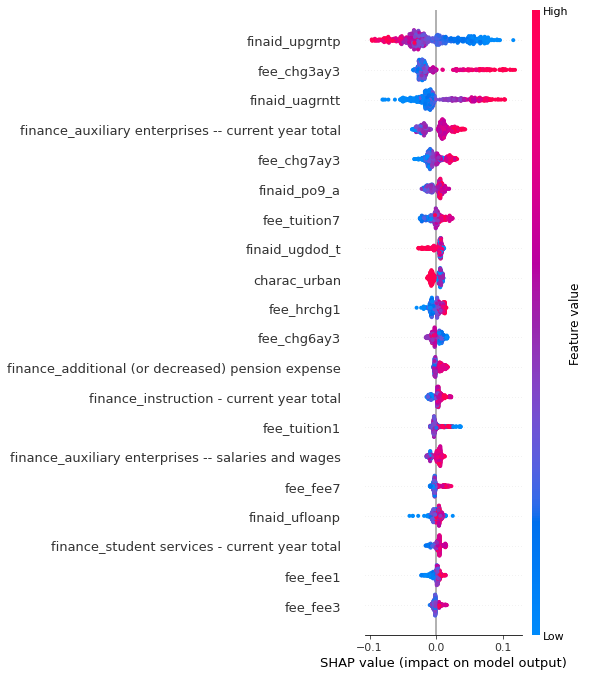

In [130]:
shap.summary_plot(shap_values, test_x)


In [39]:
train['completion_stem']
# train[train.columns[train.columns.to_series().str.contains('stem')]]

,finance_other postemployment benefit (opeb) expense,finance_other postemployment benefit (opeb) net liability,finance_deferred inflows related to other postemployment benefit (opeb),finance_deferred outflows related to other postemployment benefit (opeb),finance_postemployment benefits other than pension (opeb) reported,completion_stem,completion_stem_men,completion_stem_women,completion_stem_asian,completion_stem_black,...,completion_nonstem_white,completion_nonstem_hispanic,completion_nonstem_nonresident,completion_nonstem_men_pct,completion_nonstem_women_pct,completion_nonstem_asian_pct,completion_nonstem_black_pct,completion_nonstem_white_pct,completion_nonstem_hispanic_pct,completion_nonstem_nonresident_pct
1,NaN,NaN,NaN,NaN,NaN,218.0,110.0,110.0,1.0,195.0,...,51.0,2.0,3.0,0.680191,0.680191,0.002387,0.842482,0.121718,0.004773,0.007160
2,NaN,NaN,NaN,NaN,NaN,179.0,93.0,93.0,2.0,154.0,...,59.0,5.0,4.0,0.663653,0.663653,0.003617,0.846293,0.106691,0.009042,0.007233
3,NaN,NaN,NaN,NaN,NaN,202.0,109.0,109.0,1.0,180.0,...,72.0,7.0,5.0,0.675367,0.675367,0.006525,0.843393,0.117455,0.011419,0.008157
4,NaN,NaN,NaN,NaN,NaN,239.0,129.0,129.0,4.0,211.0,...,61.0,1.0,13.0,0.682566,0.682566,0.006579,0.847039,0.100329,0.001645,0.021382
5,3194812.0,52828823.0,4295130.0,2513894.0,NaN,238.0,127.0,127.0,2.0,217.0,...,53.0,3.0,6.0,0.673077,0.673077,0.003497,0.849650,0.092657,0.005245,0.010490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8038,NaN,NaN,NaN,NaN,NaN,545.0,163.0,163.0,11.0,31.0,...,1272.0,246.0,86.0,0.729016,0.729016,0.035751,0.091710,0.659067,0.127461,0.044560
8039,NaN,NaN,NaN,NaN,NaN,567.0,164.0,164.0,17.0,21.0,...,1215.0,285.0,86.0,0.727516,0.727516,0.029443,0.079764,0.650428,0.152570,0.046039
8040,-341879.0,3190164.0,147902.0,167579.0,NaN,563.0,166.0,166.0,16.0,32.0,...,1292.0,282.0,64.0,0.710189,0.710189,0.027138,0.095750,0.661546,0.144393,0.032770
8041,-687654.0,2286580.0,562428.0,198596.0,Yes - postemployment benefits other than pensi...,628.0,187.0,187.0,16.0,36.0,...,1101.0,283.0,48.0,0.703574,0.703574,0.036907,0.088459,0.644991,0.165788,0.028120


feature importance [2.03624461e-03 0.00000000e+00 8.06562975e-03 3.41194391e-04
 4.05343919e-04 1.13664975e-03 0.00000000e+00 2.57761572e-02
 0.00000000e+00 5.11173438e-03 0.00000000e+00 1.82136835e-04
 1.62447873e-03 1.58861454e-03 0.00000000e+00 2.37300503e-03
 1.08375389e-03 7.15243584e-03 0.00000000e+00 3.13654449e-03
 7.99808931e-03 3.98244197e-03 2.77860742e-03 1.55133067e-03
 4.72573098e-03 2.89369165e-03 3.69071448e-03 5.43477666e-03
 4.34009684e-03 1.25937648e-02 1.82328478e-01 1.59604978e-02
 3.21323751e-03 1.04716094e-02 4.41299416e-02 2.50075758e-02
 5.24324272e-03 4.72275494e-03 3.77025083e-03 1.60162672e-02
 2.19897572e-02 2.51788311e-02 7.10109062e-03 1.09113567e-02
 2.37558018e-02 6.58569578e-03 0.00000000e+00 7.96137005e-03
 5.38454298e-03 1.33933928e-02 9.80752520e-03 1.13646016e-02
 4.96680569e-03 1.12666655e-02 0.00000000e+00 0.00000000e+00
 6.72822236e-04 7.04164756e-03 6.55742688e-03 6.11936999e-03
 3.73144425e-03 1.17970910e-03 8.11543316e-03 1.77177042e-01
 1.87

Text(0.5, 0, 'Xgboost Feature Importance')

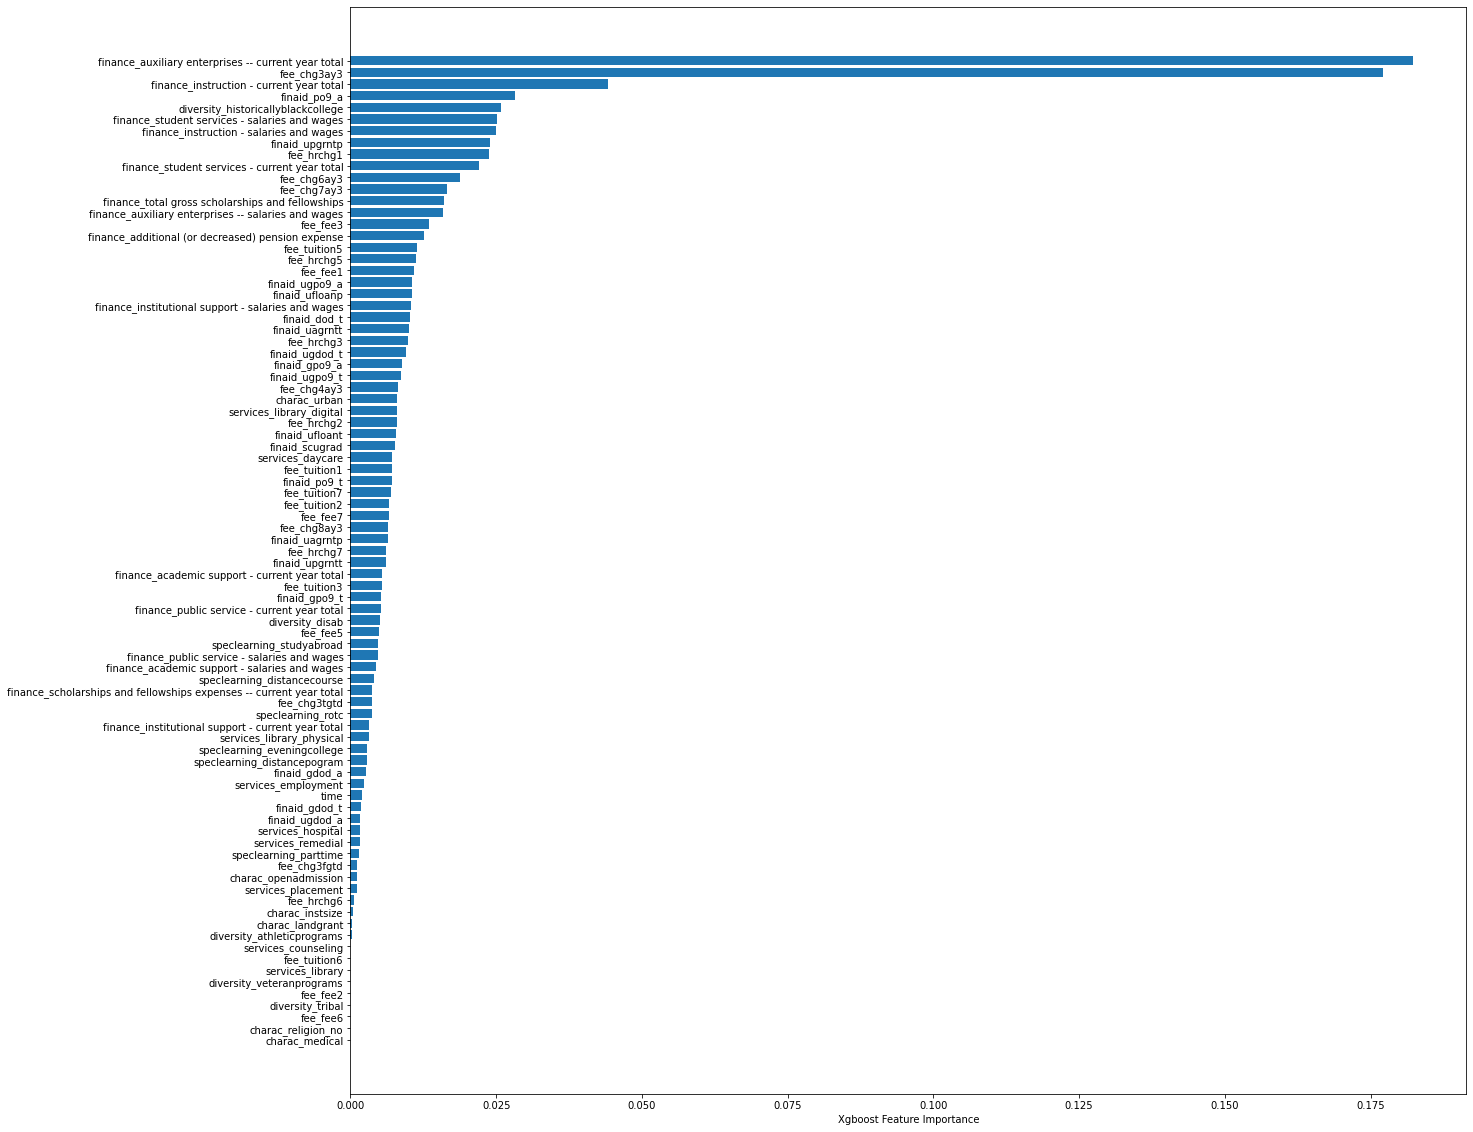

In [21]:
print(f'feature importance {regressor.feature_importances_}')
plt.rcParams["figure.figsize"] = (20,20)
sorted_idx = regressor.feature_importances_.argsort()
# s = sorted_idx[:10]
plt.barh(train_x.columns[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

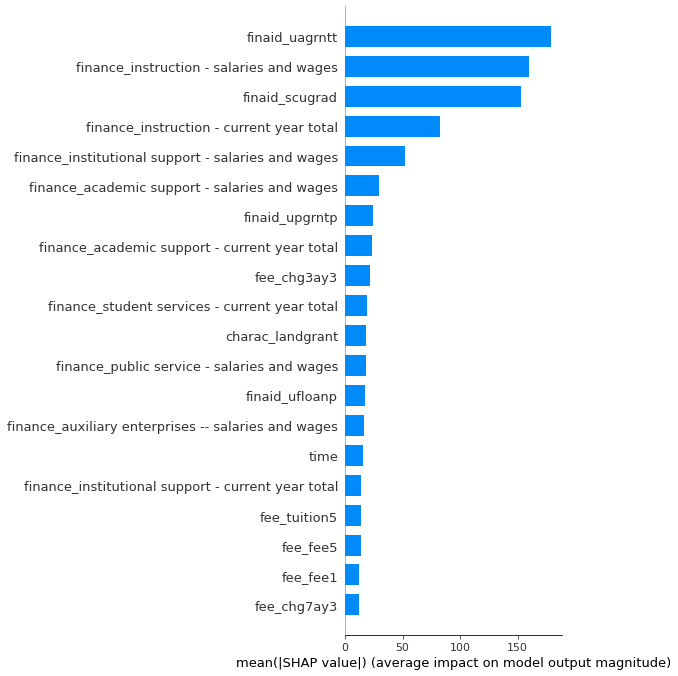

In [49]:
import shap
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(test_x)
shap.summary_plot(shap_values, test_x, plot_type="bar")

Text(0.5, 0, 'Permutation Importance')

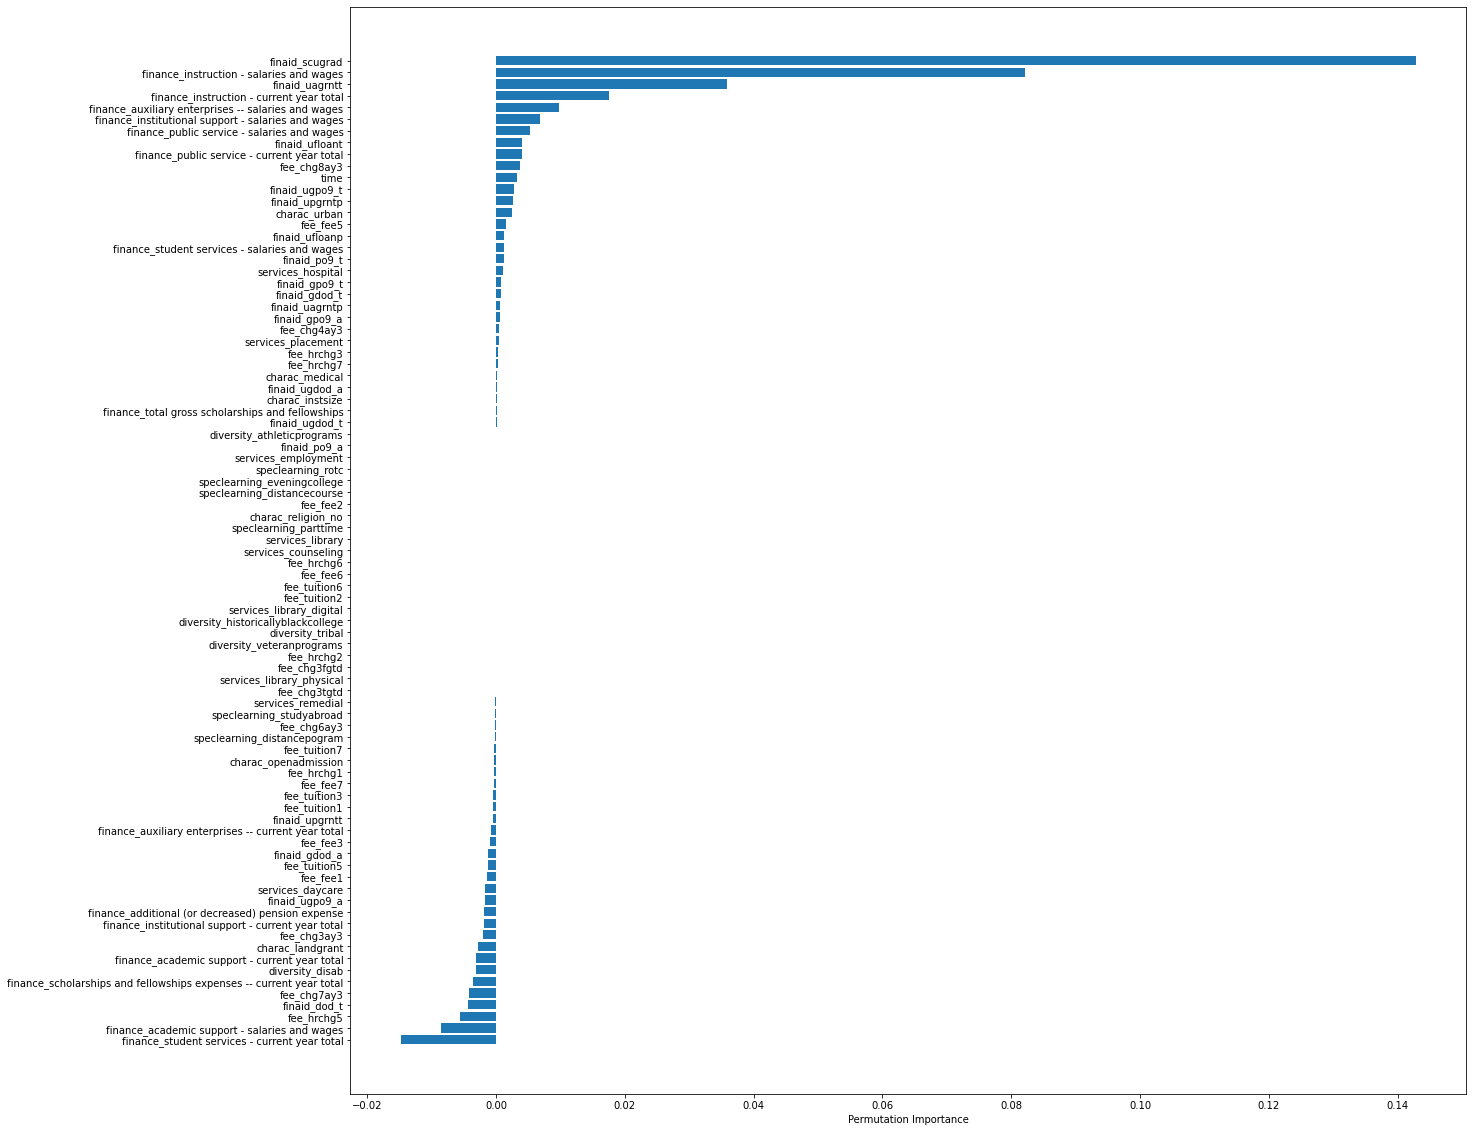

In [50]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(regressor, test_x, test_y)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(test_x.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [26]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.7 MB/s 


In [ ]:
train_x.mean()

finance_total current assets            1.576609e+08
finance_total current liabilities       7.846445e+07
finance_long-term debt                  1.956641e+08
finance_total noncurrent liabilities    3.915038e+08
finance_total liabilities               4.699682e+08
                                            ...     
fee_chg4ay3                             1.272963e+03
fee_chg3ay3                             2.024881e+04
fee_chg6ay3                             3.031693e+03
fee_chg7ay3                             1.001918e+04
fee_chg8ay3                             3.798641e+03
Length: 112, dtype: float64

In [39]:
train[train.columns[train.columns.str.startswith("gradrate_")]]

,gradrate_4yr_total_,gradrate_4yr_completer150_,gradrate_4yr_transfer_,gradrate_4yr_nocompleteren_,gradrate_4yr_nocompleter_,gradrate_2yr_total_,gradrate_2yr_completer150_,gradrate_2yr_transfer_,gradrate_2yr_nocompleteren_,gradrate_2yr_nocompleter_,...,gradrate_2yr_total_asian,gradrate_2yr_completer150_asian,gradrate_2yr_transfer_asian,gradrate_2yr_nocompleteren_asian,gradrate_2yr_nocompleter_asian,gradrate_other_total_asian,gradrate_other_completer150_asian,gradrate_other_transfer_asian,gradrate_other_nocompleteren_asian,gradrate_other_nocompleter_asian


In [ ]:
import random
import tqdm
import copy
num_feature = 2000
seq_length = 3
window = seq_length + 1
epochs =3

trainloader = [data[i] for i in range(len(data) - 1)]
trained_keywords = data.selected_keywords
test_data = data[-1]

# model = Transformer(num_node, seq_length).cuda()
model=PolynomialRegression(num_feature)
# model.init_embed(data.keyword_embeddings)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def _get_ranks(x):
    tmp = x.argsort()
    ranks = torch.zeros_like(tmp)
    ranks[tmp] = torch.arange(len(x), device=x.device)
    return ranks

def spearman_correlation(x, y):
    x_rank = _get_ranks(x)
    y_rank = _get_ranks(y)
    n = x.size(0)
    upper = 6 * torch.sum((x_rank - y_rank).pow(2))
    down = n * (n ** 2 - 1.0)
    return 1.0 - (upper / down)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, LEConv, ASAPooling
from torch_sparse import SparseTensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer


class PolynomialRegression(nn.Module):
    def __init__(self, num_nodes, deg=3, **kw) -> None:
        super(PolynomialRegression, self).__init__()
        self.deg = deg
        self.weights_list = nn.ModuleList() 
        for _ in range(deg + 1):
            # include bias
            self.weights_list.add_module(
                nn.Parameter(torch.randn(num_nodes)) # polynomial weights
            )
        
    def forward(self, unshifted_nodes):
        predicted = torch.zeros_like(unshifted_nodes) + self.weights_list[0]
        T = len(unshifted_nodes)
        for d, w in enumerate(self.weights_list):
            for j in range(1, T + 1):
                # shift by one in prediction
                predicted[j] += w * j ** (d + 1)
        return predicted
class PositionalEncoding(nn.Module):
    def __init__(self, d_model=256, dropout=0.2, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, max_len=10, ninp=256, nhead=8, nhid=256, nlayers=2, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout, max_len=max_len)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.ninp = ninp

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, node_embed, has_mask=True):
        if has_mask:
            device = node_embed.device
            if self.src_mask is None or self.src_mask.size(0) != len(node_embed):
                mask = self._generate_square_subsequent_mask(len(node_embed)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None
        node_embed = self.pos_encoder(node_embed)
        output = self.transformer_encoder(node_embed, self.src_mask)
        return output


class NodeEncoder(nn.Module):
    def __init__(self, embed_dim=768, latent_dim=256, dropout=0.2):
        super(NodeEncoder, self).__init__()
        self.gc1 = LEConv(embed_dim, latent_dim)
        self.drop = nn.Dropout(dropout)
        
    def forward(self, x, E_idx, E_w):
        x = F.relu(self.gc1(x, E_idx, E_w))
        x = self.drop(x)
        return x
class TimeSeriesEncoder(nn.Module):
    def __init__(self, nhid=256, nlayers=10, dropout=0.2):
        super(TimeSeriesEncoder, self).__init__()
        self.lstm = nn.LSTM(nhid, nhid, nlayers, dropout=dropout)
        self.nlayers = nlayers
        self.nhid = nhid
        
    def forward(self, x, h):
        return self.lstm(x, h)

    def init_hidden(self, num_node):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, num_node, self.nhid),
                    weight.new_zeros(self.nlayers, num_node, self.nhid))
        
class NodePredictorHead(nn.Module):
    def __init__(self, latent_dim=256, sec_dim=64, dropout=0.2):
        super(NodePredictorHead, self).__init__()
        self.fc1 = nn.Linear(latent_dim, sec_dim)
        self.fc2 = nn.Linear(sec_dim, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, num_nodes, T, node_pred=True) -> None:
        super(Transformer, self).__init__()
        self.num_nodes = num_nodes
        self.latent_dim = 256
        self.node_embed = nn.Embedding(num_nodes, 768)
        self.node_encoder = NodeEncoder(latent_dim=self.latent_dim)
        self.time_series_encoder = TransformerModel(ninp=self.latent_dim, max_len=T)
        self.predictor = NodePredictorHead(latent_dim=self.latent_dim)

    def init_embed(self, embed_matrix):
        self.node_embed.weight.data.copy_(embed_matrix.data)

    def forward(self, E_indices, E_weights):
        x_embeds = []
        embed = self.node_embed(torch.arange(self.num_nodes).cuda())
        T = len(E_indices)
        for E_idx, E_w in zip(E_indices, E_weights):
            x_embed = self.node_encoder(embed, E_idx, E_w)
            x_embeds.append(x_embed)
        x_embeds = torch.vstack(x_embeds).view(T, self.num_nodes, self.latent_dim)
        y = self.time_series_encoder(x_embeds, has_mask=False)
        return self.predictor(y)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43557 entries, 0 to 43556
Columns: 324 entries, unitid to year
dtypes: float64(312), int64(12)
memory usage: 107.7 MB


In [ ]:
@torch.no_grad()
def evaluate(eval_low=50, eval_high=500):
    model.eval()
    # hidden = model.init_hidden(num_node)
    # unshifted_E_idx, unshifted_E_w, shifted_E_idx, shifted_E_w, unshifted_node_cnt, shifted_node_cnt = test_data
    testx, testy = test
    output = model(testx) 
    s_out = spearman_correlation(output, testy) 
    return output, s_out

def train(counter):
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0
    # hidden = model.init_hidden(num_node)
    random.shuffle(trainloader)
    for x,y in trainloader:
        model.zero_grad()
        output = model(x)
        print(output.shape, y.shape, x.shape)
        loss = criterion(output,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        counter.update(1)

    cur_loss = total_loss / len(trainloader)
    # lr_scheduler.step(cur_loss)
    print('| epoch {:3d} | loss {:5.2f}'.format(epoch, cur_loss))
    total_loss = 0

best_model = None
best_spearman_pred = -torch.inf
best_pred = None
counter = tqdm(range(epochs * len(trainloader)))
try:
    for epoch in range(1, epochs + 1):
        train(counter)
        next_year_pred, spearman_pred = evaluate()
        if best_spearman_pred < spearman_pred:
            best_spearman_pred = spearman_pred
            best_pred = next_year_pred
            best_model = copy.deepcopy(model)

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')



In [ ]:
data[['unitid', 'year']].groupby('year').count()

,unitid
year,
2014,6959
2015,6543
2016,6394
2017,6114
2018,5909
2019,5859
2020,5779


In [ ]:
data['year'] = data['year'].apply(lambda x: int('20'+str(x)[:2]))

In [ ]:

#uagrntp: Number of undergraduate students awarded federal, state, local, institutional or other sources of grant aid
#uagrntn: Number of undergraduate students awarded federal, state, local, institutional or other sources of grant aid
#uagrntt:Total amount of Pell grant aid awarded to undergraduate students
#upgrntn: Number of undergraduate students awarded Pell grants
#upgrntp:Percent of undergraduate students awarded Pell grants
#upgrntt: Total amount of Pell grant aid awarded to undergraduate students
#ufloann: Number of undergraduate students awarded federal student loans
#ufloanp: Percent of undergraduate students awarded federal student loans
#ufloant: Total amount of federal student loans awarded to undergraduate students

df=data[data.columns[data.notnull().all()]]

In [ ]:
df3.to_csv('/content/drive/.shortcut-targets-by-id/1VhaW8PqOm10rxodZbXmRV2GHxBJq9Qxh/Data Open Championship 2022/2-data/preprocessed/finaid.csv')

In [ ]:
df.head()

,unitid,scugrad,uagrntn,uagrntp,uagrntt,upgrntn,upgrntp,upgrntt,ufloann,ufloanp,ufloant,year
0,100654,4210,3554,84,27193270,3052,72,14741945,3435,82,27837874,2014
1,100663,11679,6724,58,46518444,4093,35,16991112,6094,52,44722633,2014
2,100690,279,247,89,1149391,208,75,775545,245,88,2075604,2014
3,100706,5618,3301,59,24140595,1786,32,7613859,2578,46,18927727,2014
4,100724,4805,4508,94,34388468,3636,76,15424078,3696,77,31330798,2014


In [ ]:
data.isna().sum().reset_index().sort_values(0).iloc[12:20]

,index,0
2,scugffn,18
3,scugffp,18
29,uagrnta,308
33,upgrnta,649
52,pgrnt_t,2151
59,sgrnt_p,2151
58,sgrnt_n,2151
56,ofgrt_t,2151


In [ ]:
df.groupby(['year']).mean().reset_index()

,year,unitid,scugrad,uagrntn,uagrntp,uagrntt,upgrntn,upgrntp,upgrntt,ufloann,ufloanp,ufloant
0,2014,287445.269579,2634.857594,1626.023136,68.380227,1.245389e+07,1027.227188,51.842794,4.093780e+06,1001.584279,50.660296,6.822854e+06
1,2015,284406.851444,2748.016506,1654.086046,66.888430,1.320503e+07,1008.942228,49.405624,4.074374e+06,996.501452,48.865047,6.730783e+06
2,2016,284444.853144,2793.090241,1662.211135,66.385361,1.378355e+07,989.761182,48.105568,4.013560e+06,994.781827,48.231467,6.649039e+06
3,2017,283455.701178,2883.443899,1724.313052,65.832188,1.521997e+07,1017.872260,47.163395,4.355441e+06,984.174190,46.178443,6.581895e+06
4,2018,282972.251988,2962.165679,1769.140125,65.221526,1.632861e+07,1021.299882,45.973430,4.511784e+06,969.606532,44.633948,6.417867e+06
5,2019,283909.624339,2972.451442,1853.391022,67.327018,1.748251e+07,1013.569892,45.469193,4.563101e+06,941.394265,44.020993,6.218608e+06
6,2020,283771.282575,2905.664648,1860.328950,67.314414,1.793626e+07,944.264406,43.269770,4.320386e+06,870.572936,42.029763,5.740026e+06


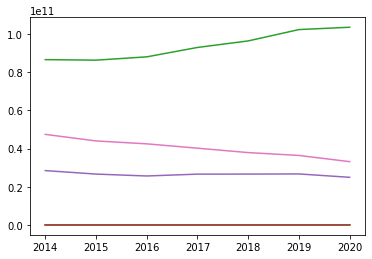

In [ ]:
df_number=df.groupby(['year']).sum().reset_index()
# df_number.drop(['uagrntp','upgrntp','ufloanp'])
# sns.set(rc={'figure.figsize':(18,10)})
# sns.lineplot(data=df_number, x='year', y='scugrad')
import matplotlib.pyplot as plt

for i in df_number.columns:
  if i not in['year','unitid','uagrntp','upgrntp','ufloanp']:
    plt.plot(df_number['year'], df_number[i])
plt.show()
    # sns.regplot(x='year', y=i, data=df_number[i], ax=axs[0])


- EFIA_2015-2021_data.csv

- Dataset Overview: 12-month instructional activity. 


In [ ]:
df2 = pd.read_csv(path + '/Student Financial Aid/SFAV_1415-2021_data.csv')

df2.head()

,unitid,ugpo9_n,ugpo9_t,ugpo9_a,gpo9_n,gpo9_t,gpo9_a,po9_n,po9_t,po9_a,ugdod_n,ugdod_t,ugdod_a,gdod_n,gdod_t,gdod_a,dod_n,dod_t,year
0,100654,73.0,389395.0,5334.0,12.0,56548.0,4712.0,85,445943,5246.0,21.0,62629.0,2982.0,2.0,5500.0,2750.0,23.0,68129.0,1415
1,100663,302.0,2236517.0,7406.0,116.0,978962.0,8439.0,418,3215479,7693.0,28.0,75188.0,2685.0,6.0,10959.0,1827.0,34.0,86147.0,1415
2,100690,13.0,109115.0,8393.0,31.0,217144.0,7005.0,44,326259,7415.0,15.0,35500.0,2367.0,10.0,24350.0,2435.0,25.0,59850.0,1415
3,100706,283.0,2158346.0,7627.0,45.0,245521.0,5456.0,328,2403867,7329.0,17.0,41437.0,2437.0,3.0,4500.0,1500.0,20.0,45937.0,1415
4,100724,36.0,218112.0,6059.0,2.0,10191.0,5096.0,38,228303,6008.0,12.0,38752.0,3229.0,1.0,3000.0,3000.0,13.0,41752.0,1415


In [ ]:
df2['year'] = df2['year'].apply(lambda x: int('20'+str(x)[:2]))

In [ ]:
len(df['year']), len(df2)

(43557, 45047)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45047 entries, 0 to 45046
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   unitid   45047 non-null  int64  
 1   ugpo9_n  43559 non-null  float64
 2   ugpo9_t  43559 non-null  float64
 3   ugpo9_a  32789 non-null  float64
 4   gpo9_n   14339 non-null  float64
 5   gpo9_t   14339 non-null  float64
 6   gpo9_a   11232 non-null  float64
 7   po9_n    45047 non-null  int64  
 8   po9_t    45047 non-null  int64  
 9   po9_a    34460 non-null  float64
 10  ugdod_n  43559 non-null  float64
 11  ugdod_t  43559 non-null  float64
 12  ugdod_a  10872 non-null  float64
 13  gdod_n   14338 non-null  float64
 14  gdod_t   14338 non-null  float64
 15  gdod_a   4574 non-null   float64
 16  dod_n    45046 non-null  float64
 17  dod_t    45046 non-null  float64
 18  year     45047 non-null  int64  
dtypes: float64(15), int64(4)
memory usage: 6.5 MB


In [ ]:
df3=pd.merge(df, df2, on=['year','unitid'], how='inner')

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43557 entries, 0 to 43556
Data columns (total 29 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   unitid   43557 non-null  int64  
 1   scugrad  43557 non-null  int64  
 2   uagrntn  43557 non-null  int64  
 3   uagrntp  43557 non-null  int64  
 4   uagrntt  43557 non-null  int64  
 5   upgrntn  43557 non-null  int64  
 6   upgrntp  43557 non-null  int64  
 7   upgrntt  43557 non-null  int64  
 8   ufloann  43557 non-null  int64  
 9   ufloanp  43557 non-null  int64  
 10  ufloant  43557 non-null  int64  
 11  year     43557 non-null  int64  
 12  ugpo9_n  43557 non-null  float64
 13  ugpo9_t  43557 non-null  float64
 14  ugpo9_a  32789 non-null  float64
 15  gpo9_n   12851 non-null  float64
 16  gpo9_t   12851 non-null  float64
 17  gpo9_a   9772 non-null   float64
 18  po9_n    43557 non-null  int64  
 19  po9_t    43557 non-null  int64  
 20  po9_a    33000 non-null  float64
 21  ugdod_n  435

In [ ]:
df2[df2['unitid']==100654]

,unitid,ugpo9_n,ugpo9_t,ugpo9_a,gpo9_n,gpo9_t,gpo9_a,po9_n,po9_t,po9_a,ugdod_n,ugdod_t,ugdod_a,gdod_n,gdod_t,gdod_a,dod_n,dod_t,year
0,100654,73.0,389395.0,5334.0,12.0,56548.0,4712.0,85,445943,5246.0,21.0,62629.0,2982.0,2.0,5500.0,2750.0,23.0,68129.0,2014
7185,100654,65.0,445249.0,6850.0,12.0,66683.0,5557.0,77,511932,6648.0,22.0,64152.0,2916.0,4.0,10756.0,2689.0,26.0,74908.0,2015
13958,100654,74.0,459035.0,6203.0,14.0,104332.0,7452.0,88,563367,6402.0,706.0,3004448.0,4256.0,34.0,141425.0,4160.0,740.0,3145873.0,2016
20563,100654,66.0,477708.0,7238.0,16.0,118292.0,7393.0,82,596000,7268.0,4.0,17882.0,4471.0,0.0,0.0,NaN,4.0,17882.0,2017
26892,100654,29.0,211473.0,7292.0,7.0,49898.0,7128.0,36,261371,7260.0,4.0,12717.0,3179.0,0.0,0.0,NaN,4.0,12717.0,2018
33009,100654,60.0,573340.0,9556.0,12.0,120189.0,10016.0,72,693529,9632.0,6.0,16407.0,2735.0,2.0,3750.0,1875.0,8.0,20157.0,2019
39073,100654,303.0,2038558.0,6728.0,48.0,460888.0,9602.0,351,2499446,7121.0,7.0,29702.0,4243.0,2.0,6000.0,3000.0,9.0,35702.0,2020


Academic Libraries

Admission and Test Scores

Completions

In [ ]:
s = set(dfc.cipcode)
'Cloud Computing' in s

True

In [ ]:
!pip install pdfminer.six

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 7.4 MB/s 
     |████████████████████████████████| 4.0 MB 54.5 MB/s 


In [ ]:
path= '/content/drive/.shortcut-targets-by-id/1VhaW8PqOm10rxodZbXmRV2GHxBJq9Qxh/Data Open Championship 2022/2-data/stemList2022.pdf'


In [ ]:
import pdfminer.high_level

p = pdfminer.high_level.extract_text(path)
plist=p.split('\n')
for i,p in enumerate(plist):
  plist[i]=p.strip().replace('.','')
stem=set()
for course in s:
  if course in plist:
    stem.add(course)
  # else:
    # print(course)
len(stem)

In [ ]:
# from top2vec import Top2Vec
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.6 MB/s 
     |████████████████████████████████| 5.8 MB 19.9 MB/s 
     |████████████████████████████████| 1.3 MB 39.1 MB/s 
     |████████████████████████████████| 182 kB 52.3 MB/s 
     |████████████████████████████████| 7.6 MB 41.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=1d41122c6b6713452b43ee0b9438165c1d38eb85436154054acc374f43113124
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
inputs = list(map(model.encode, courses))

In [ ]:
path = '/content/drive/.shortcut-targets-by-id/1VhaW8PqOm10rxodZbXmRV2GHxBJq9Qxh/Data Open Championship 2022/2-data/IPEDS_Dataset_Encoded'


In [ ]:
from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
pca = PCA(n_components=20)
i = pca.fit_transform(inputs)

In [ ]:
! pip install hdbscan
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
cluster_labels = clusterer.fit_predict(i)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.cluster import KMeans
k = KMeans(n_clusters=2)
labels = k.fit_predict(i)

In [ ]:
stems=set()
for l,c in zip(labels, courses):
  if l == 1:
    # stems.add(c)
    print(c)
# len(stems)

Agricultural Production Operations, Other
Heating, Air Conditioning, Ventilation and Refrigeration Maintenance Technology/
Computer Science
3-D Modeling and Design Technology/Technician
Science Technologies/Technicians, General
Radiologic Technology/Science - Radiographer
Manufacturing Engineering Technology/Technician
Combat Systems Engineering
Computer/Information Technology Services Administration and Management, Other
Technical and Scientific Communication
Environmental/Environmental Engineering Technology/Technician
Robotics Technology/Technician
Electrical/Electronics Equipment Installation and Repair Technology/Technician, General
Electrical and Computer Engineering
Computer and Information Sciences, General
Construction Management
Engineering-Related Fields, Other
Industrial Mechanics and Maintenance Technology
Vehicle Maintenance and Repair Technology/Technician, General
Logistics, Materials, and Supply Chain Management
Heavy/Industrial Equipment Maintenance Technologies, Othe

In [ ]:
len(set(stems).union(stem))

608

In [ ]:
stem_string=','.join(stem)

In [ ]:
with open('/content/drive/.shortcut-targets-by-id/1VhaW8PqOm10rxodZbXmRV2GHxBJq9Qxh/Data Open Championship 2022/2-data/stem.txt','w') as f:
  f.write(str(stem))

In [ ]:
stems

{'3-D Modeling and Design Technology/Technician',
 'Aeronautical/Aerospace Engineering Technology/Technician',
 'Aeronautics/Aviation/Aerospace Science and Technology, General',
 'Aerospace Ground Equipment Technology',
 'Aerospace Physiology and Medicine',
 'Aerospace, Aeronautical and Astronautical/Space Engineering',
 'Aerospace, Aeronautical, and Astronautical/Space Engineering, General',
 'Agricultural Business Technology',
 'Agricultural Business Technology/Technician',
 'Agricultural Engineering',
 'Agricultural Mechanics and Equipment/Machine Technology',
 'Agricultural Mechanics and Equipment/Machine Technology/Technician',
 'Agricultural Power Machinery Operation',
 'Agricultural Production Operations, Other',
 'Air Transportation, Other',
 'Air and Space Operations Technology',
 'Airframe Mechanics and Aircraft Maintenance Technology/Technician',
 'Alternative Fuel Vehicle Technology/Technician',
 'Appliance Installation and Repair Technology/Technician',
 'Applied Engineeri

In [ ]:
labels[:20]

['Social Science Teacher Education',
 'Dance Therapy/Therapist',
 'Herbalism/Herbalist',
 'College/Postsecondary/University Teaching',
 "Children's and Adolescent Literature",
 'Medical Administrative/Executive Assistant and Medical Secretary',
 'Musical Theatre',
 'Agricultural Production Operations, Other',
 'Heating, Air Conditioning, Ventilation and Refrigeration Maintenance Technology/',
 'Cultural Studies/Critical Theory and Analysis',
 'Health Communication',
 'American Indian/Native American Studies',
 'Computer Science',
 '3-D Modeling and Design Technology/Technician',
 'Talmudic Studies',
 'Sales and Marketing Operations/Marketing and Distribution   Teacher Education',
 'Medical Family Therapy/Therapist',
 'Long Term Care Administration/Management',
 'Science Technologies/Technicians, General',
 'Veterinary Administrative/Executive Assistant and Veterinary Secretary']

In [ ]:
dfc = pd.read_csv(path + '/Completions/C_C_2015-2021_data.csv')

df = dfc[['awlevelc', 'year', 'csund18', 'cs18_24', 'cs25_39', 'csabv40']].groupby(['year', 'awlevelc']).sum()

df = df.reset_index()
yr_lst = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
age_lst = ['csund18', 'cs18_24', 'cs25_39', 'csabv40']

df1 = dfc.groupby('year').sum().reset_index()
df1

,year,unitid,cstotlt,cstotlm,cstotlw,csaiant,csasiat,csbkaat,cshispt,csnhpit,cswhitt,cs2mort,csunknt,csnralt,csund18,cs18_24,cs25_39,csabv40
0,2015,4501271291,4795668,1973240,2822428,32839,258754,566003,662329,13981,2657018,110572,251437,242735,18043,2232387,1888597,625219
1,2016,4347532872,4818414,1993147,2825267,31664,267502,557683,699408,13455,2620694,124461,230998,272549,19350,2296595,1886645,594861
2,2017,4288306339,4866804,2019352,2847452,31414,279551,555320,739280,13391,2611774,132724,211712,291638,21930,2356505,1887664,578876
3,2018,4180894468,4933426,2046919,2886507,31302,294185,554149,779626,13502,2613101,143777,200813,302971,27567,2425128,1883823,568336
4,2019,3978729772,4999151,2061453,2937698,30680,306640,554195,822579,13249,2611856,154248,205413,300291,31610,2496688,1899723,561824
5,2020,4071081544,5000447,2043623,2956824,29285,314749,544897,850905,12694,2578802,162663,203015,303437,31281,2547533,1860849,553823
6,2021,4078251979,5108198,2038196,3070002,29778,329326,571580,899113,12977,2592903,170394,212061,290066,34181,2583588,1906701,576582


In [ ]:
df['csund18'][df.year == 2015].div(df1['csund18'][df1.year == 2015][0])

d = {1:[], 2:[], 3:[], 4:[]}
count = 0
for i in yr_lst:
  sub_count = 1
  for j in age_lst:
    a = df[j][df.year == i].div(df1[j][df1.year == i][count])
    d[sub_count].extend(a)
    sub_count += 1
  count += 1
for i in range(4):
  df[age_lst[i]] = d[i + 1]
df

,year,awlevelc,csund18,cs18_24,cs25_39,csabv40
0,2015,Associate's degree,0.254836,0.203391,0.199331,0.220755
1,2015,Award of at least 1 but less than 4 academic y...,0.240038,0.100261,0.099492,0.109344
2,2015,Award of less than 1 academic year,0.478246,0.073408,0.090073,0.138748
3,2015,Bachelor's degree,0.011473,0.560180,0.259206,0.232330
4,2015,Doctor's degree,0.000222,0.004363,0.076596,0.039236
5,2015,Master's degree,0.014133,0.055517,0.258357,0.234020
6,2015,Postbaccalaureate or Post-master's certificate,0.001053,0.002880,0.016945,0.025567
7,2016,Associate's degree,0.286615,0.204987,0.193581,0.204478
8,2016,Award of at least 1 but less than 4 academic y...,0.172972,0.095353,0.095180,0.101913
9,2016,Award of less than 1 academic year,0.528630,0.073885,0.089250,0.137869


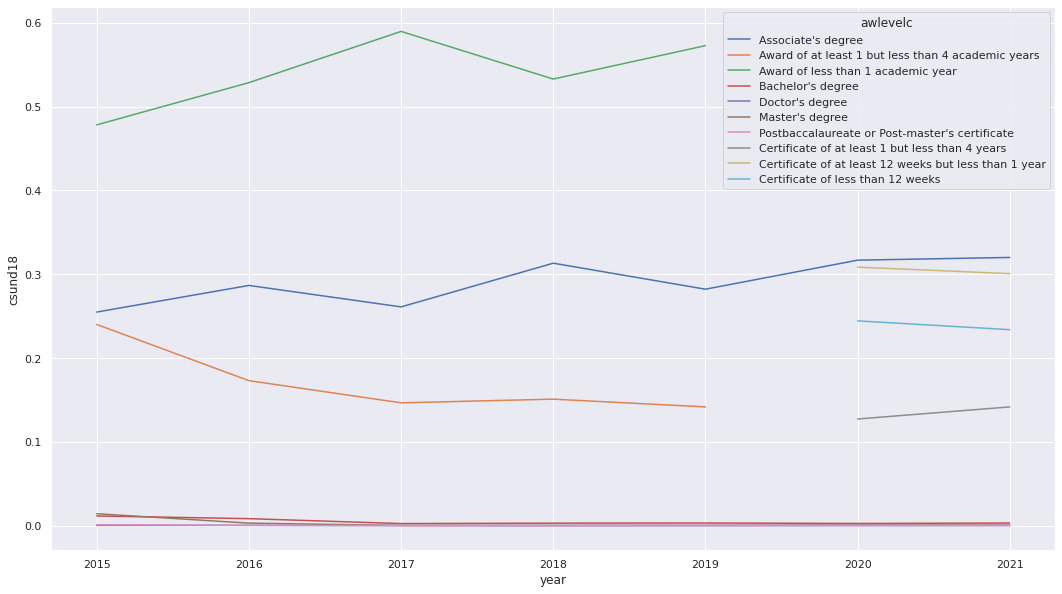

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.lineplot(data=df, x='year', y='csund18', hue='awlevelc')

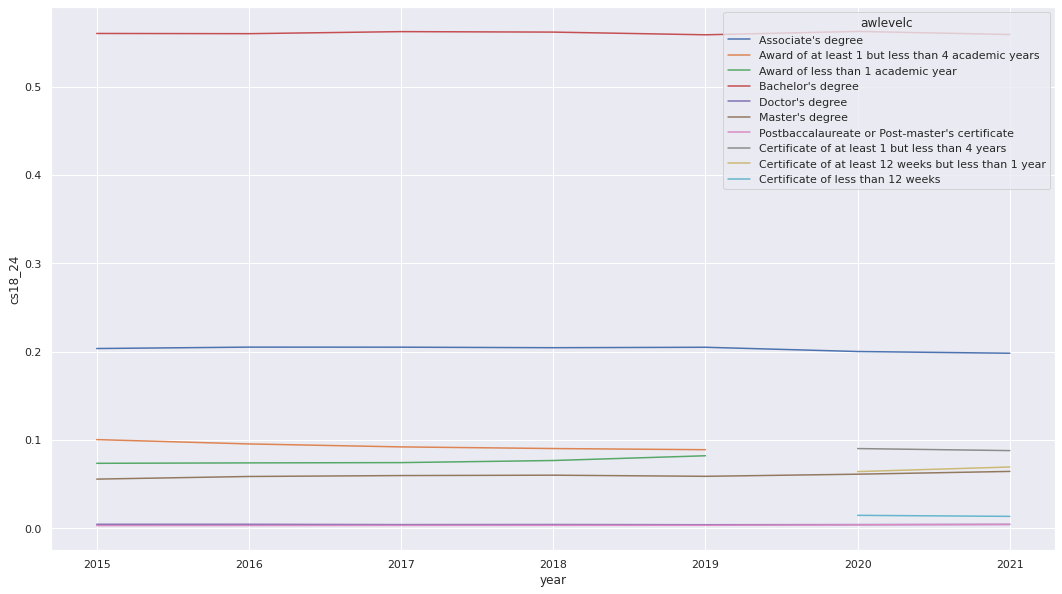

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.lineplot(data=df, x='year', y='cs18_24', hue='awlevelc')

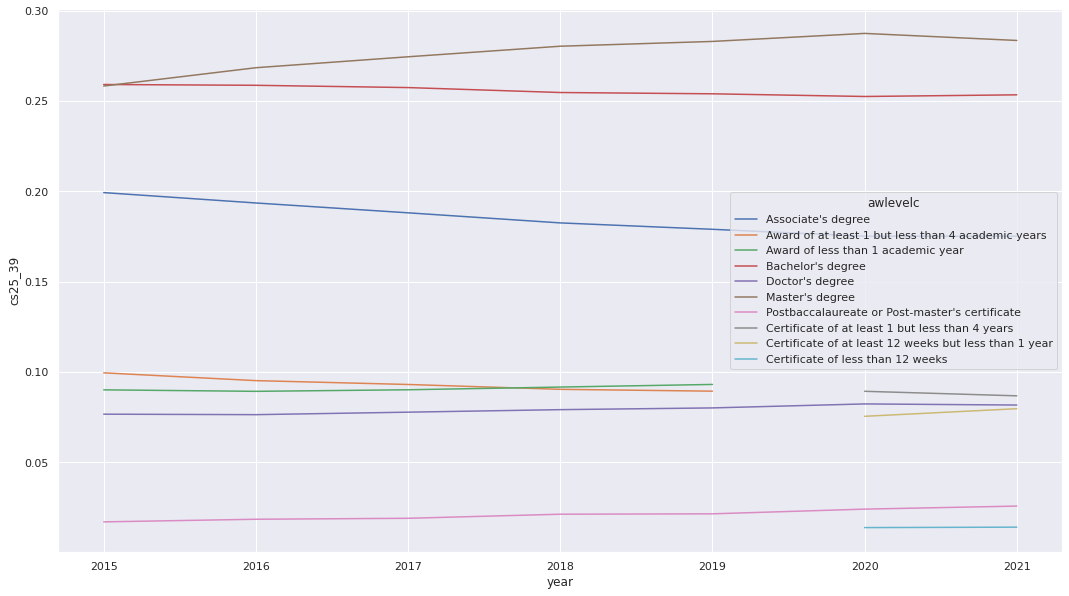

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.lineplot(data=df, x='year', y='cs25_39', hue='awlevelc')

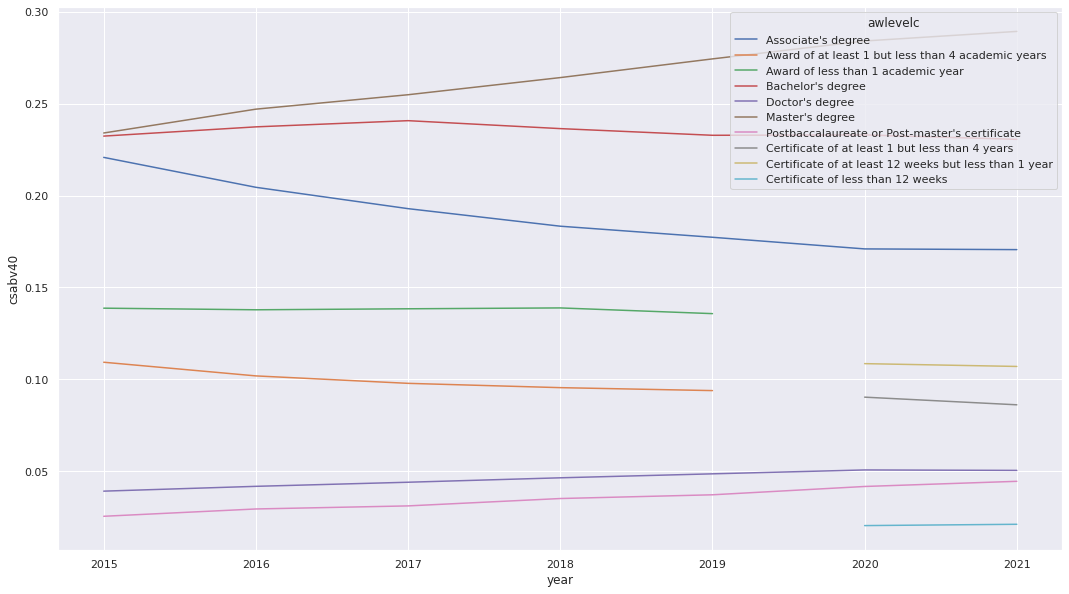

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.lineplot(data=df, x='year', y='csabv40', hue='awlevelc')